In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import torch.nn.functional as F

import math


In [2]:

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


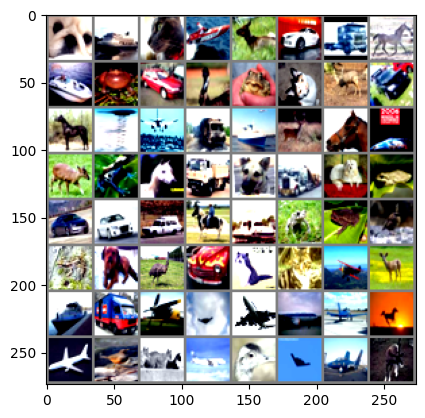

dog ship cat ship deer automobile truck horse ship frog automobile bird frog cat deer automobile horse airplane airplane truck ship deer horse automobile deer frog horse truck dog truck dog frog automobile automobile automobile horse ship frog frog bird frog dog bird automobile cat cat airplane deer ship truck airplane airplane airplane airplane airplane horse airplane bird cat airplane bird airplane airplane deer


In [3]:


import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(64)))


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Linear projection of flattened patches
        self.projection = nn.Conv2d(
            self.num_channels, 
            self.hidden_size, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadDifferentialAttention(nn.Module):

    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  

        qkv = self.qkv_proj(x) 
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) 
        q, k, v = qkv[0], qkv[1], qkv[2]  


        k_padded = torch.cat([torch.zeros_like(k[:, :, :1, :]), k], dim=2)  
        diff_k = k_padded[:, :, 1:, :] - k_padded[:, :, :-1, :] 

        attn_weights = torch.matmul(q, diff_k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        context = torch.matmul(attn_probs, v)
        
        context = context.transpose(1, 2).reshape(B, N, D)

        out = self.out_proj(context)
        return out


class DiffViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.norm1 = nn.LayerNorm(input_dim)

        self.attn = MultiHeadDifferentialAttention(input_dim, num_heads, dropout)
 
        self.norm2 = nn.LayerNorm(input_dim)

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):

        x = x + self.attn(self.norm1(x))

        x = x + self.mlp(self.norm2(x))
        return x


class DiffViTClassifier(nn.Module):
    def __init__(
        self, image_size, patch_size, num_channels, embed_dim, hidden_dim, num_heads,
        num_layers, num_classes, dropout=0.0
    ):
        super().__init__()
        
        patch_config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": embed_dim
        }

        self.patch_embedding = PatchEmbeddings(patch_config)
        self.num_patches = self.patch_embedding.num_patches
        
 
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
       

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        self.dropout = nn.Dropout(dropout)
        
    
        self.transformer = nn.Sequential(
            *[DiffViTEncoder(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
       
        self.norm = nn.LayerNorm(embed_dim)
   
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
    
        B = x.shape[0]
        
    
        x = self.patch_embedding(x)  
        
      
        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1)  
        
        x = x + self.pos_embed  
        x = self.dropout(x)
        
      
        x = self.transformer(x)
        
      
        x = self.norm(x)
        
        
        x = x[:, 0]  # (B, embed_dim)
        
    
        x = self.head(x)  # (B, num_classes)
        
        return x

In [6]:
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import random
import math



Running experiment with baseline augmentation
Using mixup: False

Using device: cuda
Augmentation config: baseline
Using mixup: False
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.0481, Acc: 23.38%
Epoch [1/20], Step [200/782], Loss: 1.8884, Acc: 26.48%
Epoch [1/20], Step [300/782], Loss: 1.8004, Acc: 28.31%
Epoch [1/20], Step [400/782], Loss: 1.7478, Acc: 29.94%
Epoch [1/20], Step [500/782], Loss: 1.6948, Acc: 31.27%
Epoch [1/20], Step [600/782], Loss: 1.6441, Acc: 32.52%
Epoch [1/20], Step [700/782], Loss: 1.5757, Acc: 33.82%
Epoch [1/20] - Test Loss: 1.5681, Test Acc: 42.52%
New best model saved with accuracy: 42.52%
Epoch [2/20], Step [100/782], Loss: 1.5069, Acc: 45.41%
Epoch [2/20], Step [200/782], Loss: 1.4578, Acc: 45.95%
Epoch [2/20], Step [300/782], Loss: 1.4530, Acc: 46.58%
Epoch [2/20], Step [400/782], Loss: 1.3990, Acc: 47.05%
Epoch [2/20], Step [500/782], Loss: 1.3852, Acc: 47.51%
Epoch [2/20], Step [60

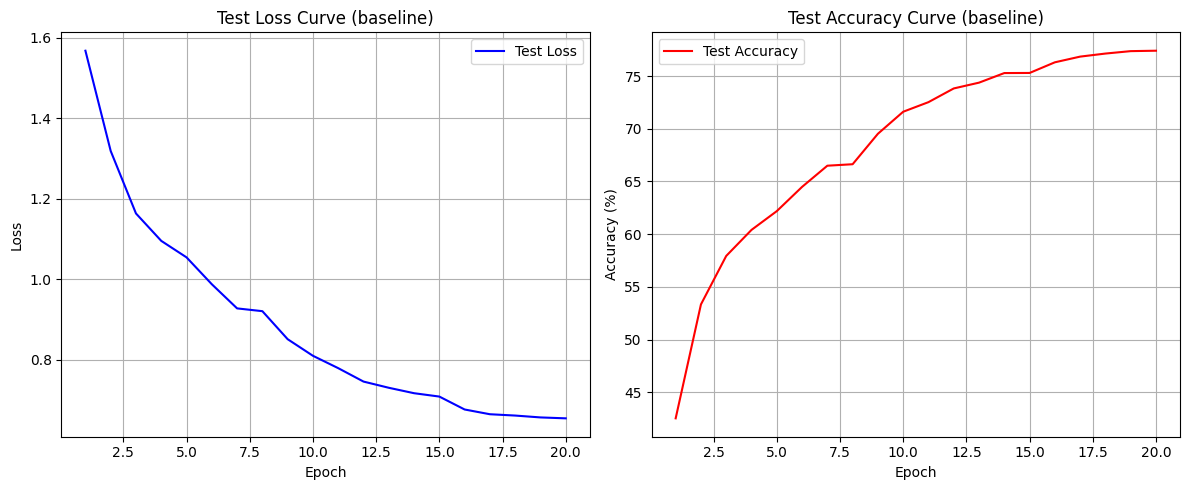

Final test accuracy: 77.40%
Best test accuracy: 77.40%


Running experiment with cutout augmentation
Using mixup: False

Using device: cuda
Augmentation config: cutout
Using mixup: False
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.0951, Acc: 21.12%
Epoch [1/20], Step [200/782], Loss: 1.9537, Acc: 23.66%
Epoch [1/20], Step [300/782], Loss: 1.9221, Acc: 25.10%
Epoch [1/20], Step [400/782], Loss: 1.8589, Acc: 26.46%
Epoch [1/20], Step [500/782], Loss: 1.8351, Acc: 27.43%
Epoch [1/20], Step [600/782], Loss: 1.8056, Acc: 28.38%
Epoch [1/20], Step [700/782], Loss: 1.7853, Acc: 29.16%
Epoch [1/20] - Test Loss: 1.6833, Test Acc: 38.91%
New best model saved with accuracy: 38.91%
Epoch [2/20], Step [100/782], Loss: 1.6966, Acc: 38.39%
Epoch [2/20], Step [200/782], Loss: 1.6718, Acc: 38.83%
Epoch [2/20], Step [300/782], Loss: 1.6642, Acc: 38.67%
Epoch [2/20], Step [400/782], Loss: 1.6451, Acc: 39.12%
Epoch [2/20], Step [500/782

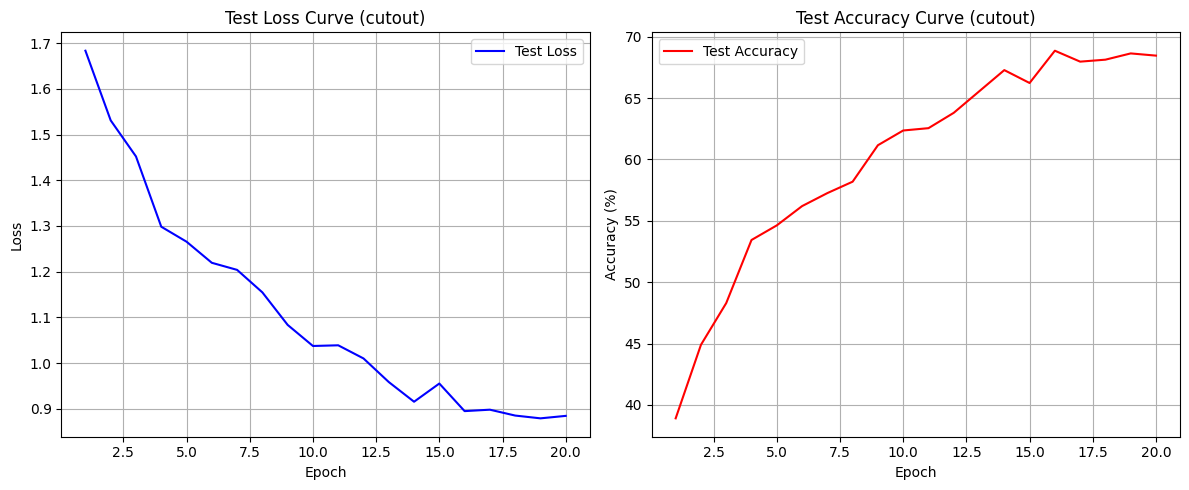

Final test accuracy: 68.46%
Best test accuracy: 68.86%


Running experiment with custom_policy augmentation
Using mixup: False

Using device: cuda
Augmentation config: custom_policy
Using mixup: False
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.0956, Acc: 21.39%
Epoch [1/20], Step [200/782], Loss: 1.9588, Acc: 23.55%
Epoch [1/20], Step [300/782], Loss: 1.9070, Acc: 25.08%
Epoch [1/20], Step [400/782], Loss: 1.8409, Acc: 26.39%
Epoch [1/20], Step [500/782], Loss: 1.7880, Acc: 27.73%
Epoch [1/20], Step [600/782], Loss: 1.7591, Acc: 28.82%
Epoch [1/20], Step [700/782], Loss: 1.7172, Acc: 29.91%
Epoch [1/20] - Test Loss: 1.5685, Test Acc: 42.10%
New best model saved with accuracy: 42.10%
Epoch [2/20], Step [100/782], Loss: 1.6557, Acc: 39.42%
Epoch [2/20], Step [200/782], Loss: 1.6319, Acc: 39.59%
Epoch [2/20], Step [300/782], Loss: 1.5905, Acc: 40.48%
Epoch [2/20], Step [400/782], Loss: 1.5615, Acc: 40.96%
Epoch [2/20],

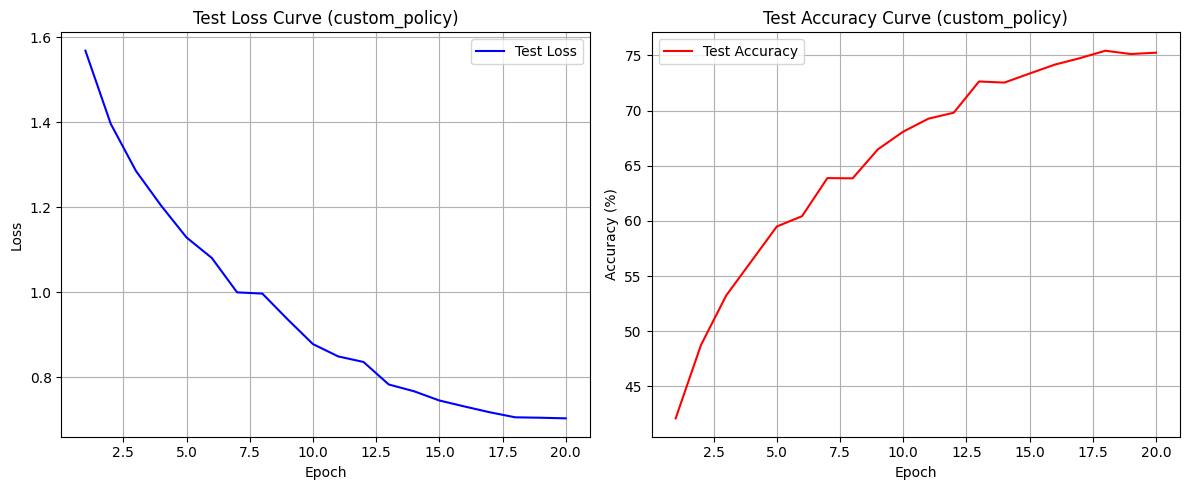

Final test accuracy: 75.25%
Best test accuracy: 75.43%


Running experiment with custom_cutout augmentation
Using mixup: False

Using device: cuda
Augmentation config: custom_cutout
Using mixup: False
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.1415, Acc: 19.56%
Epoch [1/20], Step [200/782], Loss: 2.0363, Acc: 21.30%
Epoch [1/20], Step [300/782], Loss: 1.9933, Acc: 22.67%
Epoch [1/20], Step [400/782], Loss: 1.9651, Acc: 23.66%
Epoch [1/20], Step [500/782], Loss: 1.9433, Acc: 24.48%
Epoch [1/20], Step [600/782], Loss: 1.9126, Acc: 25.15%
Epoch [1/20], Step [700/782], Loss: 1.8743, Acc: 25.90%
Epoch [1/20] - Test Loss: 1.7897, Test Acc: 35.16%
New best model saved with accuracy: 35.16%
Epoch [2/20], Step [100/782], Loss: 1.8324, Acc: 31.88%
Epoch [2/20], Step [200/782], Loss: 1.8293, Acc: 32.05%
Epoch [2/20], Step [300/782], Loss: 1.7926, Acc: 32.58%
Epoch [2/20], Step [400/782], Loss: 1.7912, Acc: 32.89%
Epoch [2/20],

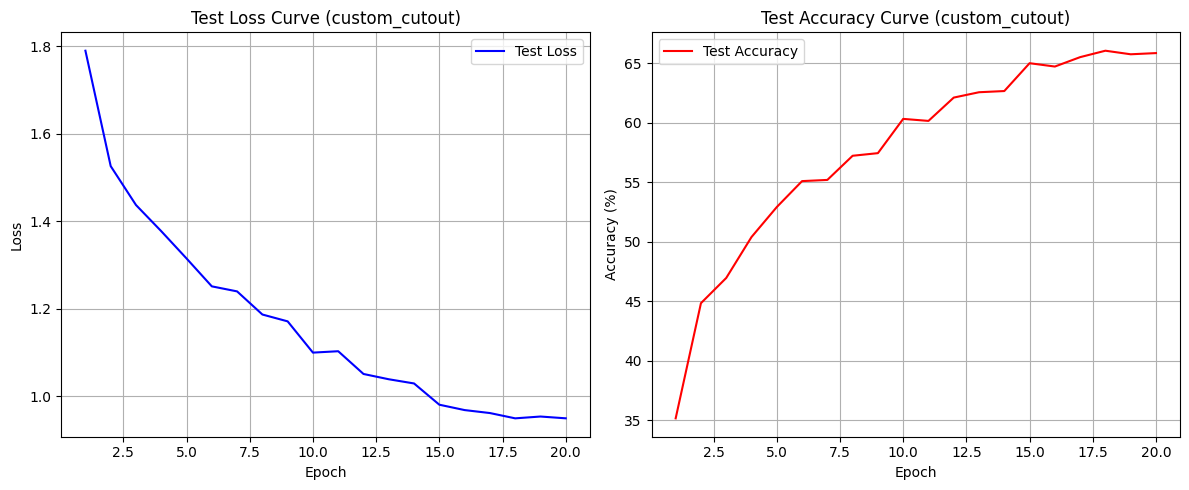

Final test accuracy: 65.86%
Best test accuracy: 66.06%


Running experiment with baseline augmentation
Using mixup: True

Using device: cuda
Augmentation config: baseline
Using mixup: True
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.1748
Epoch [1/20], Step [200/782], Loss: 2.0912
Epoch [1/20], Step [300/782], Loss: 2.0497
Epoch [1/20], Step [400/782], Loss: 2.0045
Epoch [1/20], Step [500/782], Loss: 1.9936
Epoch [1/20], Step [600/782], Loss: 1.9681
Epoch [1/20], Step [700/782], Loss: 1.9750
Epoch [1/20] - Test Loss: 1.6067, Test Acc: 42.10%
New best model saved with accuracy: 42.10%
Epoch [2/20], Step [100/782], Loss: 1.9268
Epoch [2/20], Step [200/782], Loss: 1.8865
Epoch [2/20], Step [300/782], Loss: 1.8742
Epoch [2/20], Step [400/782], Loss: 1.8638
Epoch [2/20], Step [500/782], Loss: 1.8188
Epoch [2/20], Step [600/782], Loss: 1.8242
Epoch [2/20], Step [700/782], Loss: 1.8481
Epoch [2/20] - Test Loss: 1.4840, Test 

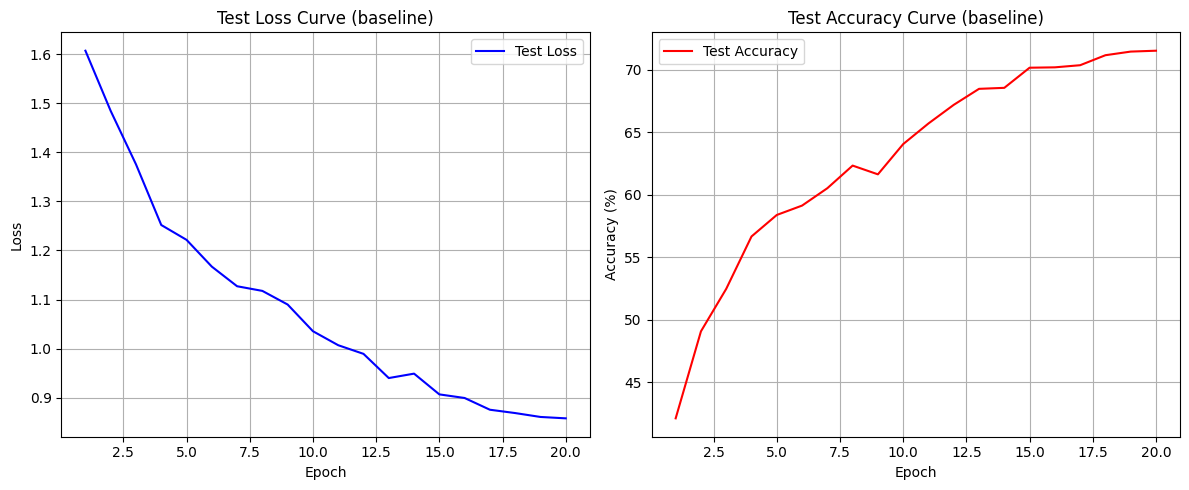

Final test accuracy: 71.51%
Best test accuracy: 71.51%


Running experiment with autoaugment augmentation
Using mixup: False

Using device: cuda
Augmentation config: autoaugment
Using mixup: False
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.1969, Acc: 18.08%
Epoch [1/20], Step [200/782], Loss: 2.0541, Acc: 20.80%
Epoch [1/20], Step [300/782], Loss: 2.0011, Acc: 22.07%
Epoch [1/20], Step [400/782], Loss: 1.9793, Acc: 23.00%
Epoch [1/20], Step [500/782], Loss: 1.8816, Acc: 24.24%
Epoch [1/20], Step [600/782], Loss: 1.8425, Acc: 25.48%
Epoch [1/20], Step [700/782], Loss: 1.8212, Acc: 26.60%
Epoch [1/20] - Test Loss: 1.5867, Test Acc: 40.89%
New best model saved with accuracy: 40.89%
Epoch [2/20], Step [100/782], Loss: 1.7753, Acc: 35.22%
Epoch [2/20], Step [200/782], Loss: 1.7586, Acc: 35.48%
Epoch [2/20], Step [300/782], Loss: 1.7135, Acc: 35.82%
Epoch [2/20], Step [400/782], Loss: 1.6825, Acc: 36.49%
Epoch [2/20], Ste

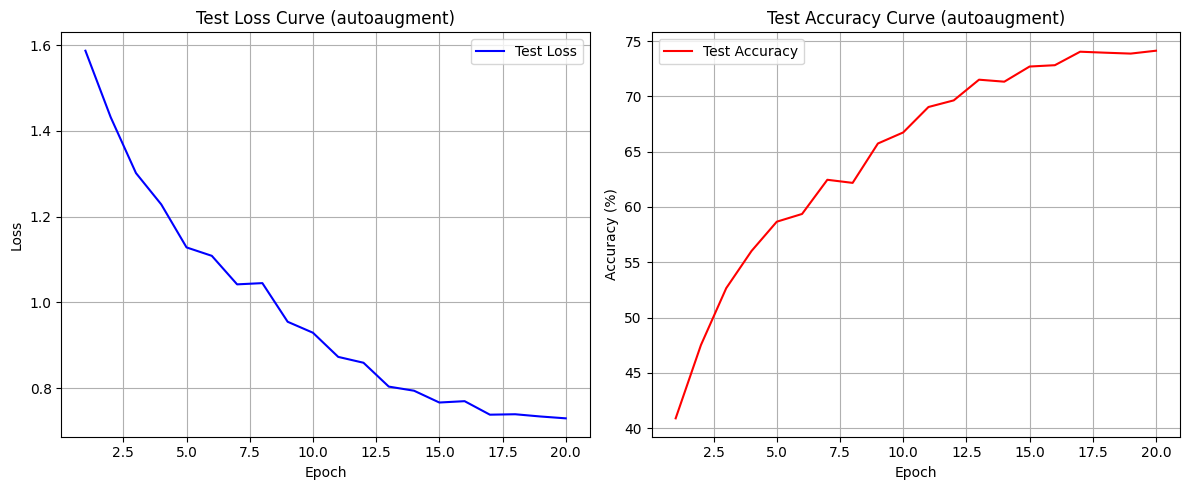

Final test accuracy: 74.13%
Best test accuracy: 74.13%


Running experiment with randaugment augmentation
Using mixup: False

Using device: cuda
Augmentation config: randaugment
Using mixup: False
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/782], Loss: 2.1480, Acc: 19.84%
Epoch [1/20], Step [200/782], Loss: 2.0024, Acc: 22.41%
Epoch [1/20], Step [300/782], Loss: 1.9216, Acc: 24.43%
Epoch [1/20], Step [400/782], Loss: 1.8807, Acc: 25.73%
Epoch [1/20], Step [500/782], Loss: 1.8277, Acc: 27.14%
Epoch [1/20], Step [600/782], Loss: 1.7934, Acc: 28.23%
Epoch [1/20], Step [700/782], Loss: 1.7562, Acc: 29.12%
Epoch [1/20] - Test Loss: 1.5601, Test Acc: 42.25%
New best model saved with accuracy: 42.25%
Epoch [2/20], Step [100/782], Loss: 1.6747, Acc: 38.67%
Epoch [2/20], Step [200/782], Loss: 1.6387, Acc: 39.19%
Epoch [2/20], Step [300/782], Loss: 1.6334, Acc: 39.36%
Epoch [2/20], Step [400/782], Loss: 1.6133, Acc: 39.66%
Epoch [2/20], Ste

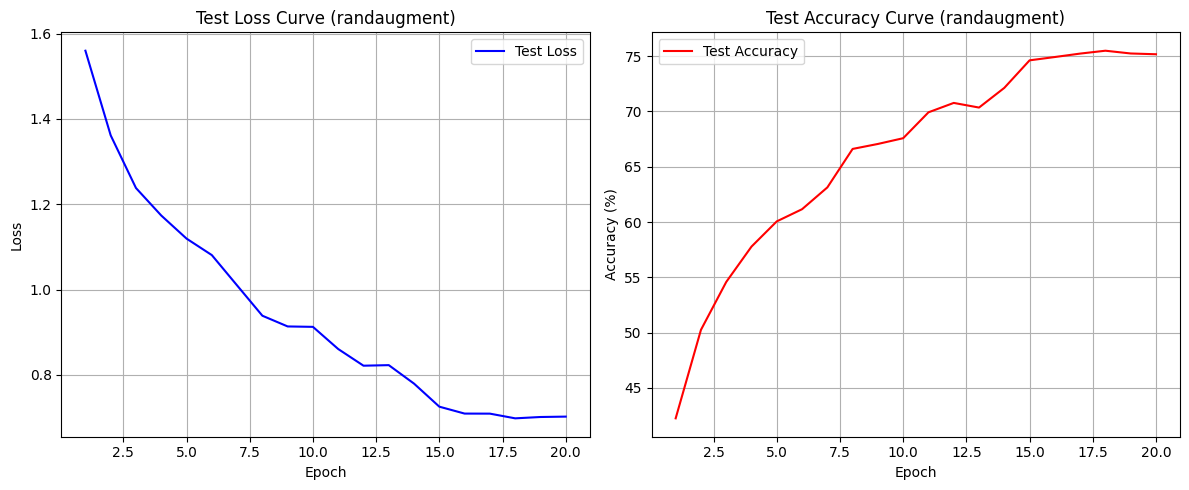

Final test accuracy: 75.17%
Best test accuracy: 75.49%


AUGMENTATION EXPERIMENT RESULTS
baseline: 77.40%
randaugment: 75.49%
custom_policy: 75.43%
autoaugment: 74.13%
baseline_mixup: 71.51%
cutout: 68.86%
custom_cutout: 66.06%

Best augmentation configuration: baseline
Best accuracy achieved: 77.40%


In [ ]:
def create_vit_for_cifar10():
    # CIFAR-10 specific configuration
    image_size = 32
    patch_size = 4
    num_channels = 3
    embed_dim = 192
    hidden_dim = 768
    num_heads = 8
    num_layers = 6
    num_classes = 10
    dropout = 0.1
    
    model = DiffViTClassifier(
        image_size=image_size,
        patch_size=patch_size,
        num_channels=num_channels,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        num_classes=num_classes,
        dropout=dropout
    )
    
    return model


class Cutout:
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length
        
    def __call__(self, img):

        h = img.size(1)
        w = img.size(2)
        
        mask = torch.ones((h, w), dtype=torch.float32)
        
        for n in range(self.n_holes):
            y = random.randint(0, h - self.length)
            x = random.randint(0, w - self.length)
            
            y1 = max(0, y)
            y2 = min(h, y + self.length)
            x1 = max(0, x)
            x2 = min(w, x + self.length)
            
            mask[y1:y2, x1:x2] = 0
        
        mask = mask.expand_as(img)
        img = img * mask
        
        return img

def mixup_data(x, y, alpha=1.0, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


try:
    from torchvision.transforms import AutoAugment, AutoAugmentPolicy
    has_autoaugment = True
except ImportError:
    has_autoaugment = False
    print("AutoAugment not available in your torchvision version")

try:
    from torchvision.transforms import RandAugment
    has_randaugment = True
except ImportError:
    has_randaugment = False
    print("RandAugment not available in your torchvision version")


class CustomCIFAR10Policy:
    def __init__(self):
        self.policies = [
            transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ]
        
    def __call__(self, img):
        for p in self.policies:
            if random.random() < 0.5:  
                img = p(img)
        return img



def get_augmentation_config(config_name):
    # Base transformations always applied for CIFAR-10
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    
    # Configuration 1: Baseline (minimal augmentation)
    if config_name == "baseline":
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    
    # Configuration 2: Standard augmentation + Cutout
    elif config_name == "cutout":
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            Cutout(n_holes=1, length=16)
        ])
    
    # Configuration 3: Custom policy
    elif config_name == "custom_policy":
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            CustomCIFAR10Policy(),
            transforms.ToTensor(),
            normalize
        ])
    
    elif config_name == "autoaugment" and has_autoaugment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            AutoAugment(AutoAugmentPolicy.CIFAR10),
            transforms.ToTensor(),
            normalize,
        ])

    elif config_name == "randaugment" and has_randaugment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            normalize,
        ])
    
    elif config_name == "custom_cutout":
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            CustomCIFAR10Policy(),
            transforms.ToTensor(),
            normalize,
            Cutout(n_holes=1, length=16)
        ])
        
    else:
        print(f"Warning: Augmentation config '{config_name}' not found, using baseline")
        return get_augmentation_config("baseline")
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    
    return train_transform, test_transform



def train_vit_on_cifar10(model, augmentation_config="baseline", use_mixup=False, 
                         num_epochs=30, batch_size=64, learning_rate=3e-4):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Augmentation config: {augmentation_config}")
    print(f"Using mixup: {use_mixup}")
    
    
    model = model.to(device)
    
    
    train_transform, test_transform = get_augmentation_config(augmentation_config)
    
   
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
 
    best_acc = 0.0
    
    # Training loop
    for epoch in range(num_epochs):
     
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
        
            inputs, labels = inputs.to(device), labels.to(device)
            
            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=1.0, device=device)
                
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            if use_mixup:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            

            running_loss += loss.item()
            
            if not use_mixup:  
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
      
            if (i + 1) % 100 == 0:
                if not use_mixup:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                          f'Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
                else:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                          f'Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        

        if not use_mixup:
            train_acc = 100. * correct / total
            train_accuracies.append(train_acc)
        

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_test_loss = test_loss / len(testloader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f'vit_cifar10_{augmentation_config}.pth')
            print(f"New best model saved with accuracy: {best_acc:.2f}%")
        
       
        scheduler.step()
    

    plt.figure(figsize=(12, 5))
    
    # Plot test loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), test_losses, 'b-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Test Loss Curve ({augmentation_config})')
    plt.legend()
    plt.grid(True)
    
    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Test Accuracy Curve ({augmentation_config})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'vit_cifar10_{augmentation_config}_curves.png')
    plt.show()
    
    # Print final test accuracy
    print(f'Final test accuracy: {test_accuracies[-1]:.2f}%')
    print(f'Best test accuracy: {best_acc:.2f}%')
    
    return best_acc, test_losses, test_accuracies


# Function to run experiments with different augmentation configurations
def run_augmentation_experiments(num_epochs=30):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    # Configurations to test
    configs = [
        {"name": "baseline", "use_mixup": False},
        {"name": "cutout", "use_mixup": False},
        {"name": "custom_policy", "use_mixup": False},
        {"name": "custom_cutout", "use_mixup": False},  # Combined custom policy + cutout
        {"name": "baseline", "use_mixup": True},  # Baseline + mixup
    ]
    
    # Add AutoAugment if available
    if has_autoaugment:
        configs.append({"name": "autoaugment", "use_mixup": False})
    
    # Add RandAugment if available
    if has_randaugment:
        configs.append({"name": "randaugment", "use_mixup": False})
    
    # Results storage
    results = []
    
    # Run experiments for each configuration
    for config in configs:
        print(f"\n\n{'='*50}")
        print(f"Running experiment with {config['name']} augmentation")
        print(f"Using mixup: {config['use_mixup']}")
        print(f"{'='*50}\n")
        
        # Create a fresh model for each experiment
        model = create_vit_for_cifar10()
        
        # Train with the current augmentation config
        best_acc, _, _ = train_vit_on_cifar10(
            model,
            augmentation_config=config['name'],
            use_mixup=config['use_mixup'],
            num_epochs=num_epochs
        )
        
        # Store results
        config_name = f"{config['name']}" + ("_mixup" if config['use_mixup'] else "")
        results.append({
            "config": config_name,
            "best_accuracy": best_acc
        })
    
    # Print summary of results
    print("\n\n" + "="*50)
    print("AUGMENTATION EXPERIMENT RESULTS")
    print("="*50)
    
    for result in sorted(results, key=lambda x: x["best_accuracy"], reverse=True):
        print(f"{result['config']}: {result['best_accuracy']:.2f}%")
    
    # Return the best configuration
    best_result = max(results, key=lambda x: x["best_accuracy"])
    return best_result



best_config = run_augmentation_experiments(num_epochs=20)
    
print(f"\nBest augmentation configuration: {best_config['config']}")
print(f"Best accuracy achieved: {best_config['best_accuracy']:.2f}%")